In [1]:
import pandas as pd
from pomegranate import HiddenMarkovModel, State, DiscreteDistribution
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Sync\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sync\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\Sync\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset
df = pd.read_csv('sms_spam.csv')
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'result', 'v2': 'message'}, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   result   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.describe()

,result,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
df.groupby('result').describe().T

result                             ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

result                                                       spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [6]:
df['num_characters'] = df['message'].apply(len)
df.head()

,result,message,num_characters
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [7]:
#create a feature with the number / count of words in message - using nltk word tokenizer (it breaks the string into list of words)
df['message'].apply(lambda x : nltk.word_tokenize(x))

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: message, Length: 5572, dtype: object

In [8]:
#store this as new feature - number of words
df['num_words'] = df['message'].apply( lambda x : len(nltk.word_tokenize(x)) )

In [9]:
#similar to word tokenizer in nltk, we can use sentence tokenizer (sent_tokenize) to create a list of sentences from text data
df['message'].apply(lambda x : nltk.sent_tokenize(x))

0       [Go until jurong point, crazy.., Available onl...
1                        [Ok lar..., Joking wif u oni...]
2       [Free entry in 2 a wkly comp to win FA Cup fin...
3       [U dun say so early hor... U c already then sa...
4       [Nah I don't think he goes to usf, he lives ar...
                              ...                        
5567    [This is the 2nd time we have tried 2 contact ...
5568              [Will Ì_ b going to esplanade fr home?]
5569    [Pity, * was in mood for that., So...any other...
5570    [The guy did some bitching but I acted like i'...
5571                        [Rofl., Its true to its name]
Name: message, Length: 5572, dtype: object

In [10]:
#we can create a new feature as number of sentences in text
df['num_sentences'] = df['message'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head()

,result,message,num_characters,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [11]:
# Count the frequency of top 5 messages.
df['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
4,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ...",4


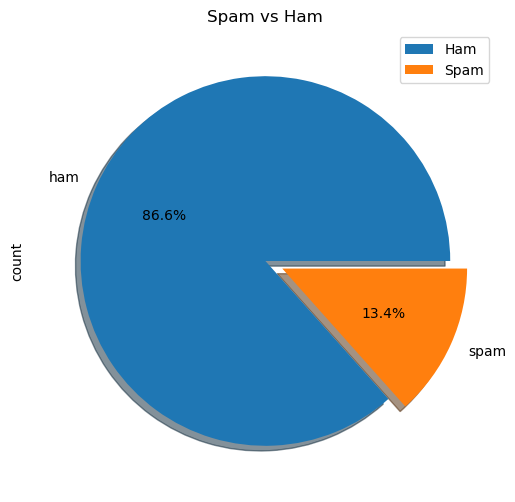

In [12]:
df["result"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

Text(0, 0.5, 'Frequency')

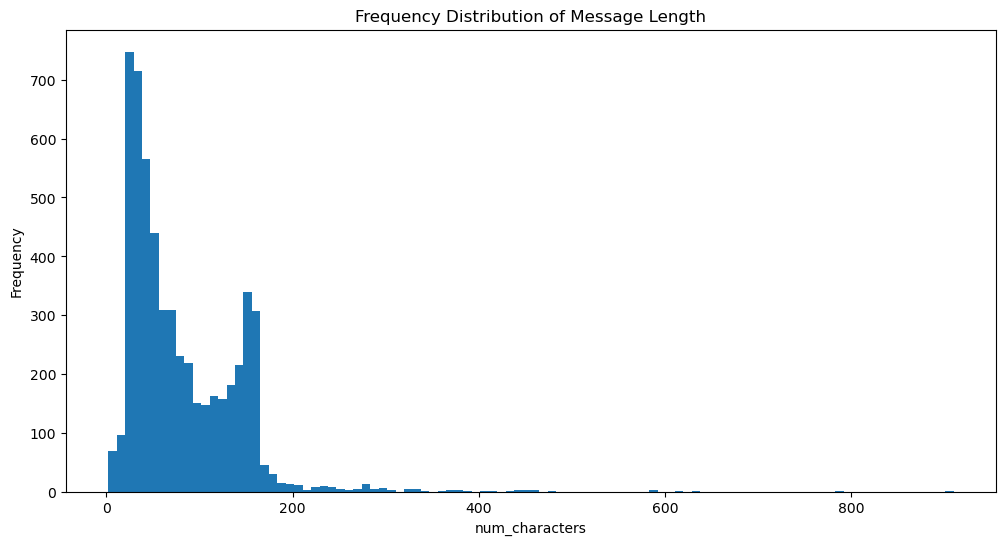

In [13]:
plt.figure(figsize=(12,6))
df['num_characters'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("num_characters")
plt.ylabel("Frequency")

In [14]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.695621,1.970747
std,59.690841,13.742587,1.417778
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,28.000000


In [15]:
df[df['result'] == 'ham'][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.271917,1.808705
std,58.016023,13.988885,1.328227
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [16]:
df[df['result'] == 'spam'][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.866131,27.891566,3.017403
std,29.183082,6.867007,1.528449
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

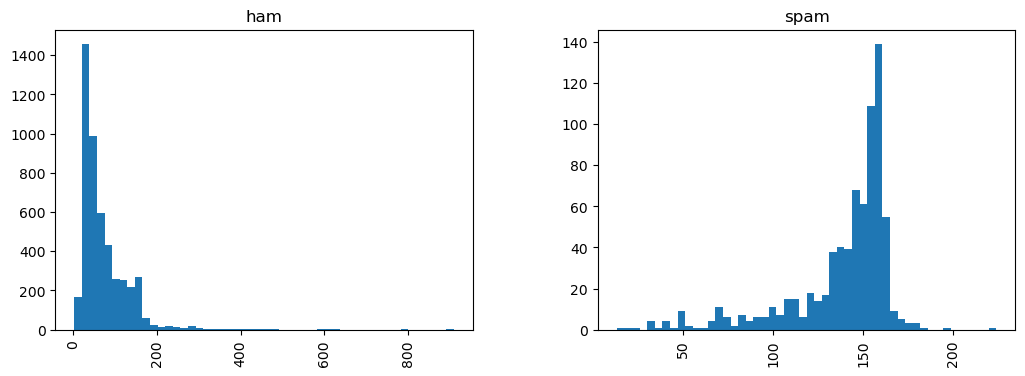

In [21]:
df.hist(column='num_characters', by='result', bins=50,figsize=(12,4))

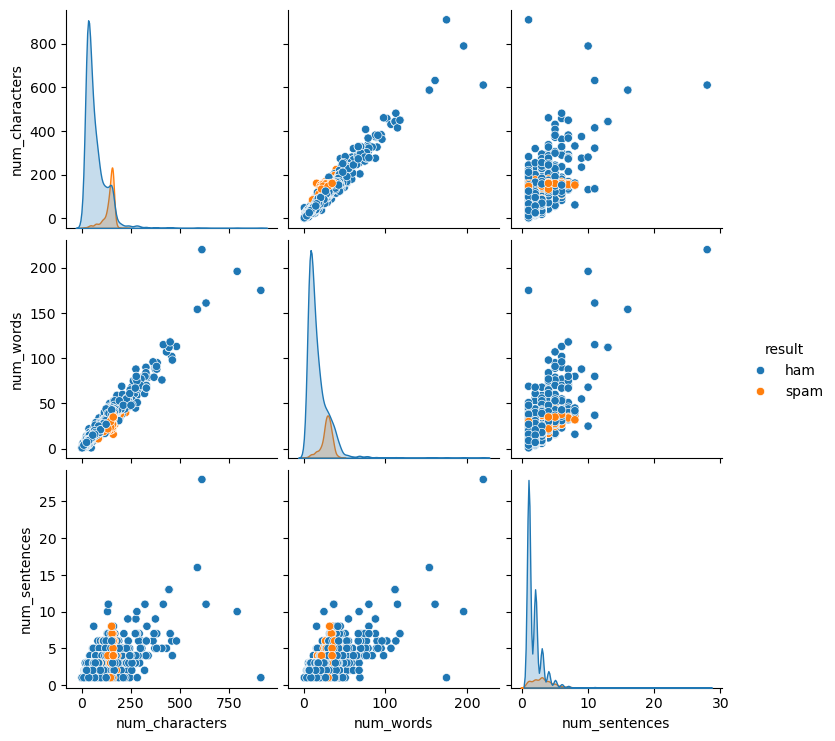

In [18]:
sns.pairplot(df, hue = 'result')

In [23]:
# Encode the target variable
encoder = LabelEncoder()
df['result'] = encoder.fit_transform(df['result'])

In [24]:
# Convert all values in 'message' column to strings
df['message'] = df['message'].astype(str)
df.head()

,result,message,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


<AxesSubplot:>

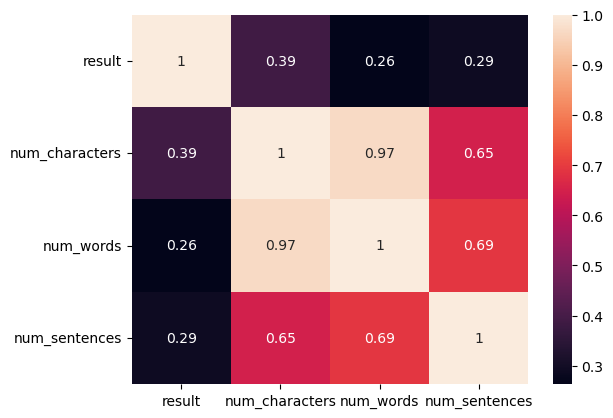

In [26]:
sns.heatmap(df[['result', 'num_characters', 'num_words', 'num_sentences']].corr(), annot = True)

In [27]:
# Define text preprocessing function
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [28]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words and perform stemming
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    
    # Remove remaining non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    return text

# Preprocess the text data
df['message'] = df['message'].apply(preprocess_text)

In [29]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['result'], test_size=0.2, random_state=42)

In [30]:
# Create a mapping between words and indices
word_to_index = {}
for sequence in X_train:
    for word in sequence.split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

In [31]:
# Define the emission probability
emission_prob = []
smoothing_factor = 0.00001
unknown_index = len(word_to_index)

In [32]:
for label in [0, 1]:
    filtered_sequences = [sequence.split() for sequence, y_label in zip(df['message'], df['result']) if y_label == label]
    word_counts = {i: sum(sequence.count(i) for sequence in filtered_sequences) for i in set().union(*filtered_sequences)}
    total_words = sum(word_counts.values())
    vocabulary = set(word_counts.keys())
    word_probs = {word: (word_counts.get(word, 0) + smoothing_factor) / (total_words + smoothing_factor * (len(vocabulary) + 1)) for word in vocabulary}
    word_probs[unknown_index] = smoothing_factor / (total_words + smoothing_factor * (len(vocabulary) + 1))
    emission_prob.append(DiscreteDistribution(word_probs))

In [33]:
# Define the transition probability (you can adjust these values)
transition_prob = [
    [0.7, 0.3],  # Transition probabilities from state 'ham'
    [0.2, 0.8]   # Transition probabilities from state 'spam'
]

# Define initial probabilities (assuming uniform distribution)
start_prob = [0.5, 0.5]

# Create the HMM model
states = [State(0, 'ham'), State(1, 'spam')]
model = HiddenMarkovModel.from_matrix(transition_prob, emission_prob, start_prob, state_names=['ham', 'spam'])

In [34]:
print("Conditional Probability Table (Emission Probabilities):")
print("Word\tP(Word|Ham)\tP(Word|Spam)")
for word, ham_prob in emission_prob[0].parameters[0].items():
    spam_prob = emission_prob[1].parameters[0].get(word, 0)
    print(f"{word}\t{ham_prob:.5f}\t{spam_prob:.5f}")

Conditional Probability Table (Emission Probabilities):
Word	P(Word|Ham)	P(Word|Spam)
stori	0.00050	0.00008
coat	0.00005	0.00000
4th	0.00015	0.00000
besid	0.00003	0.00000
smell	0.00005	0.00000
found	0.00040	0.00008
mindsetbeliev	0.00003	0.00000
passthey	0.00003	0.00000
campu	0.00015	0.00000
bottom	0.00008	0.00000
crazi	0.00025	0.00040
didt	0.00013	0.00000
acid	0.00003	0.00000
spent	0.00020	0.00000
wallet	0.00003	0.00000
ese	0.00008	0.00000
sunshin	0.00003	0.00064
chinchilla	0.00003	0.00000
howev	0.00018	0.00008
doubt	0.00005	0.00000
nang	0.00003	0.00000
cozi	0.00003	0.00000
reason	0.00050	0.00000
heri	0.00005	0.00000
burgundi	0.00003	0.00000
laid	0.00003	0.00024
de	0.00061	0.00000
damn	0.00015	0.00000
2wk	0.00003	0.00008
qbank	0.00003	0.00000
announc	0.00003	0.00048
lttr	0.00005	0.00000
christ	0.00005	0.00000
mite	0.00010	0.00000
footbal	0.00005	0.00016
dhort	0.00003	0.00000
usc	0.00005	0.00000
seriou	0.00015	0.00000
tag	0.00005	0.00000
budget	0.00015	0.00000
nite2	0.00003	0.00000
edis

In [35]:
print("\nJoint Probability Table (Transition Probabilities):")
print("From\\To\tHam\tSpam")
print("Ham\t{:.5f}\t{:.5f}".format(transition_prob[0][0], transition_prob[0][1]))
print("Spam\t{:.5f}\t{:.5f}".format(transition_prob[1][0], transition_prob[1][1]))


Joint Probability Table (Transition Probabilities):
From\To	Ham	Spam
Ham	0.70000	0.30000
Spam	0.20000	0.80000


In [36]:
# Test the HMM model
y_pred = []
for message in X_test:
    predicted_state_sequence = model.predict(message.split())
    if predicted_state_sequence:  # Check if the list is not empty
        y_pred.append(predicted_state_sequence[0])
    else:
        y_pred.append(0)  # Handle empty list case
        
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9542600896860987


Accuracy: 0.9543
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       965
           1       0.82      0.85      0.83       150

    accuracy                           0.95      1115
   macro avg       0.90      0.91      0.90      1115
weighted avg       0.95      0.95      0.95      1115



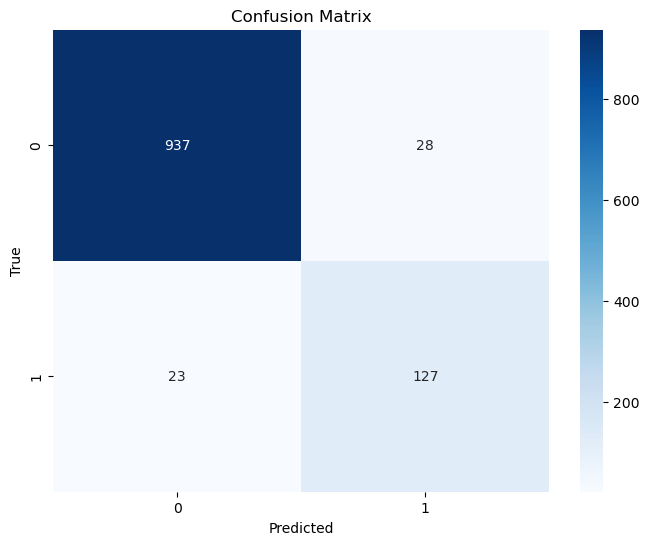

In [37]:
# Evaluate the model
accuracy_score = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy_score:.4f}')
print('Classification Report:')
print(classification_report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()